# 1. Functions

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

In [3]:
def print_time(begin_time, end_time):
    """ 
    This function prints the time in minutes that a certain task took.
    """
    print ("--------------------------------------------------")
    print ("CPU process time: %.2f [min]" % float((end-start)/60))
    print ("--------------------------------------------------")

# 2. Packages

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import arviz
import pystan
import time

In [5]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset.csv')

In [6]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# parameters of interest
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values[index].astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values[index].astype(int)                    # 1st parameter
redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

In [7]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [8]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                       # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

### 2.1 Fit: STAN code 

In [9]:
stan_code = """
// DECLARATION OF VARIABLES ------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) ---------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;       // 25 betas!
    real<lower=0> sigma;    // Shared hyperpriors
    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION -----------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
    mu ~ normal(0, 100);                                   // shared hyperpriors
     
    for (i in 1:K) {
       for (j in 1:C) beta[i,j] ~ normal(mu, sigma);       // priors
        }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED ------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        prob02[j] = inv_logit(eta02[j]);
        prob03[j] = inv_logit(eta03[j]);
        prob04[j] = inv_logit(eta04[j]);
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

### 2.2 Fit settings (for STAN)

In [10]:
iterations = 7000
chains     = 3                           # HMC chains
warmup     = 2000                        # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # Run code in parallel -- see pystan documentation
seed       = 1

In [11]:
control = {}
control['max_treedepth'] = 20
control['adapt_delta'] = 0.99

### 2.3 Running the fit

In [12]:
start = time.time()

fit = pystan.stan(model_code=stan_code, data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup,
                  n_jobs=jobs, control=control)

end = time.time()
print_time(start, end)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50fd202ecaf8992b685aa66bc38cb07a NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--------------------------------------------------
CPU process time: 12.89 [min]
--------------------------------------------------


# 3. Retrieving the data from the fit

### 3.1 Saving the entire fit: brace for impact!

In [13]:
start  = time.time()
fit_df = fit.to_dataframe()
end    = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 0.06 [min]
--------------------------------------------------


In [14]:
start = time.time()
fit_df.to_csv('../../LargeFilesResults/Model/entirefit_shared_revised.csv', index=False)
end   = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 4.89 [min]
--------------------------------------------------


### 3.2 Saving the automatic summary from STAN

In [16]:
summary = pystan.stansummary(fit=fit, digits_summary=5)

In [17]:
summary_arr  = np.array(summary.split('\n'))
summay_clean = summary_arr[5:-6,]

In [18]:
header_fit = ['parameter'] + summary_arr[4].split()

#### 3.2.1 Recovering the mass (undo the stadardization) and adding x1 and x2 to the summary

In [19]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
recovered_pars  = np.column_stack((np.squeeze(plot_x1), np.squeeze(recovered_mass)))
rp      = recovered_pars
rp_cols = np.vstack((rp, rp, rp, rp, rp))    # for 5 whan classes we must stack these 5x

#### 3.2.2 Checking if the numbers aren't overlaped

In [26]:
new_summary = list(np.zeros(len(header_fit)))
for i in range(summay_clean.size):
    if len(summay_clean[i].split())!=11: # the length of the list must be 11, in which case we connect them directly
        print (i, summay_clean[i])
    else:
        new_summ_temp = np.array(summay_clean[i].split()).reshape(1,11)
        new_summary   = np.vstack((new_summary, new_summ_temp))
new_summary = new_summary[1:,:]               # removing the zeroes in the beggining
print (new_summary[:,0].shape)

1379 eta01[453]  -0.441  0.0511 0.3278 -1.117 -0.675 -0.427 -0.1292.8917e-6     41 1.0479
1380 eta01[454]  -0.442  0.0511 0.3277 -1.117 -0.676 -0.427 -0.1307.2509e-6     41 1.0479
(9025,)


In [27]:
new_summary[1379] = 'eta01[453]  -0.441  0.0511 0.3278 -1.117 -0.675 -0.427 -0.129 2.8917e-6     41 1.0479'
new_summary[1380] = 'eta01[454]  -0.442  0.0511 0.3277 -1.117 -0.676 -0.427 -0.130 7.2509e-6     41 1.0479'

#### 3.2.3 Retrieving only the probabilities from the summary and stacking x1 and x2 at the end of the dataframe

In [29]:
parameters = new_summary[:,0].astype(str)
pnew_idxs  = []
for i in range(parameters.size):
    if parameters[i][0:4]=='prob':
        pnew_idxs.append(i)
    else:
        continue
print (new_summary[pnew_idxs,:].shape, rp_cols.shape)
model_results    = np.column_stack((new_summary[pnew_idxs,:], rp_cols))
model_results_df = pd.DataFrame(model_results)
model_results_df.columns = header_fit + ['Z'] + ['LOG_STELLAR_MASS']
model_results_df.to_csv('../../LargeFilesResults/Model/fit_summary_shared_revised.csv', header=True, index=False)

(4500, 11) (4500, 2)


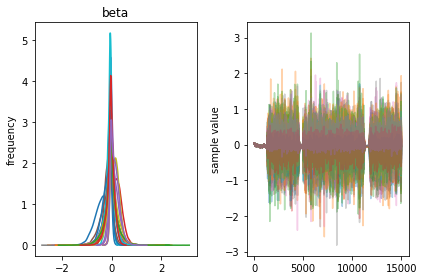

In [34]:
fit.plot('beta')
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_overall_revised.png')
plt.show()

In [42]:
posteriors = fit_df[fit.flatnames[:25]]

In [44]:
posteriors.to_csv('../../LargeFilesResults/Model/posteriors_shared_revised.csv')